## 0. Setup

### 0.1. Import

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from utils.metrics import accuracy_fn
from utils.visualization import visualize

### 0.2 Verify GPU access

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Data

### 1.1. Create a dataset

In [3]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [4]:
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.3, # how clustered data are around the centre
    random_state=RANDOM_SEED # reproducible
)

In [5]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

### 1.2. Split data into training & test sets

In [6]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

### 1.3. Visualize data

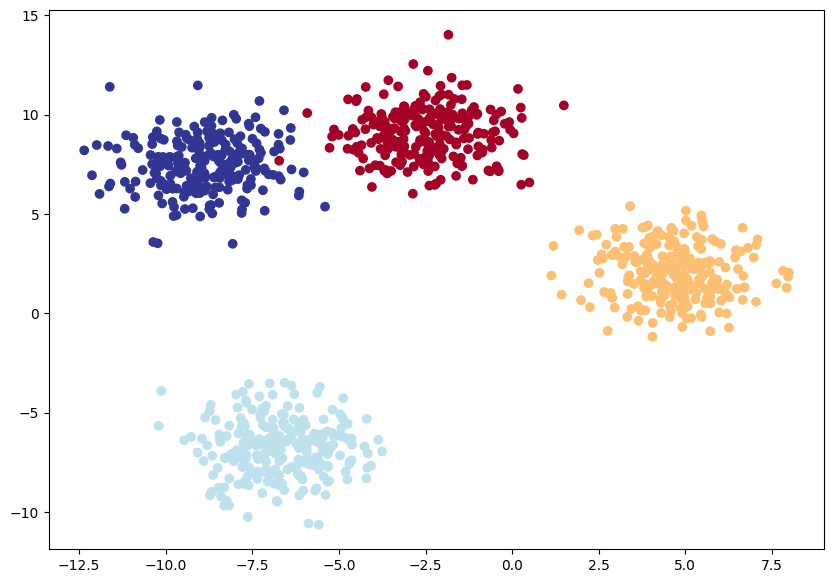

In [7]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## 2. Build a model

### 2.1. Model Class Creation
   - `BlobModel`: multi-layer perceptrons (MLPs), capable of learning complex, non-linear relationships like clustered groups.

In [8]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [9]:
model = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 3. Training

- **Loss Function**:
  - **`nn.CrossEntropyLoss`**:
    - Combines `nn.LogSoftmax` and `nn.NLLLoss` in one step for multi-class classification.
    - Suitable for tasks where the target has multiple classes.

- **Optimizer**:
  - **`torch.optim.SGD`**:
    - Optimization method: Stochastic Gradient Descent (SGD).
    - Learning Rate: `0.01`.

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.01)

### 3.2. Optimization Loop

In [11]:
torch.manual_seed(42)

epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_blob_train) # output: raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # logits -> prediction probabilities -> prediction labels (selects max prob)
    
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.31077, Acc: 25.12% | Test Loss: 1.30577, Test Acc: 24.50%
Epoch: 10 | Loss: 1.22163, Acc: 27.50% | Test Loss: 1.21983, Test Acc: 30.50%
Epoch: 20 | Loss: 1.14918, Acc: 46.88% | Test Loss: 1.14741, Test Acc: 48.50%
Epoch: 30 | Loss: 1.08639, Acc: 54.87% | Test Loss: 1.08279, Test Acc: 55.00%
Epoch: 40 | Loss: 1.02426, Acc: 61.12% | Test Loss: 1.01761, Test Acc: 60.50%
Epoch: 50 | Loss: 0.96211, Acc: 65.00% | Test Loss: 0.95179, Test Acc: 62.50%
Epoch: 60 | Loss: 0.90087, Acc: 69.00% | Test Loss: 0.88696, Test Acc: 65.50%
Epoch: 70 | Loss: 0.84236, Acc: 76.25% | Test Loss: 0.82545, Test Acc: 74.50%
Epoch: 80 | Loss: 0.78805, Acc: 83.00% | Test Loss: 0.76903, Test Acc: 81.00%
Epoch: 90 | Loss: 0.73855, Acc: 87.38% | Test Loss: 0.71835, Test Acc: 85.00%
Epoch: 100 | Loss: 0.69357, Acc: 90.12% | Test Loss: 0.67286, Test Acc: 89.50%
Epoch: 110 | Loss: 0.65229, Acc: 92.38% | Test Loss: 0.63175, Test Acc: 93.00%
Epoch: 120 | Loss: 0.61374, Acc: 93.75% | Test Loss: 0.59399, T

### 3.3. Evaluation

In [12]:
y_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


### 3.4. Visualization

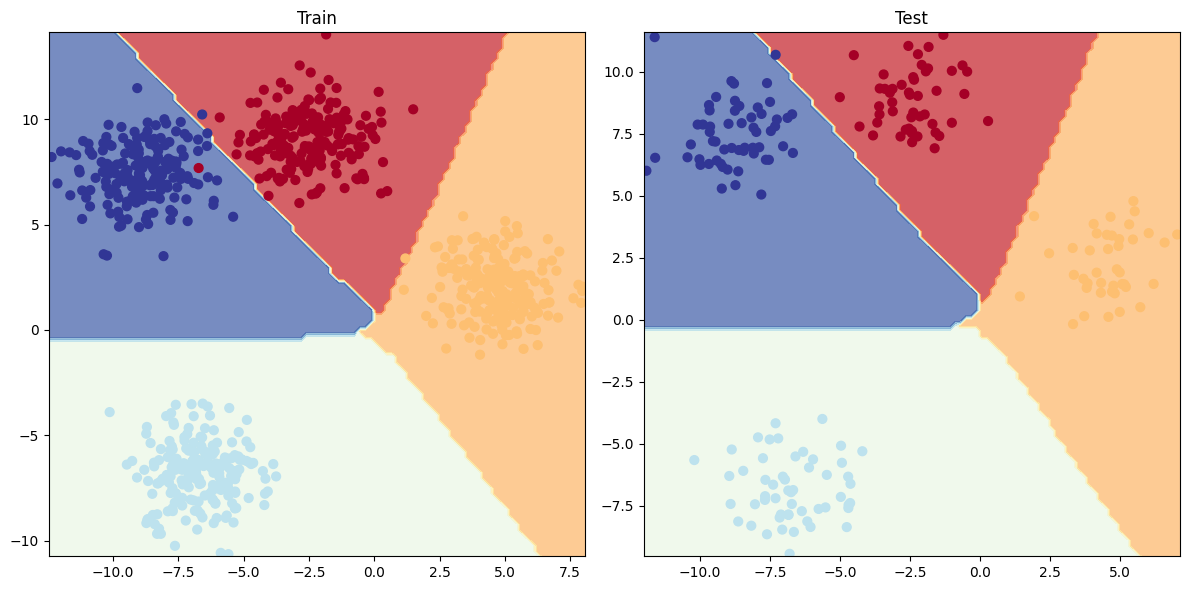

In [13]:
visualize(model, X_blob_train, y_blob_train, X_blob_test, y_blob_test)